<a href="https://colab.research.google.com/github/WVital2025/Code_thesis/blob/main/4D_Algebras_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

from scipy.linalg import hadamard

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import layers, activations, initializers
#from tensorflow.keras.losses import mean_squared_error
from keras.losses import mean_squared_error

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Function:

In [ ]:
def ftrue(X):
    return np.stack([X[:,0]**2+X[:,1]*X[:,2]+X[:,3]**2,
                     X[:,1]**2+X[:,2]*X[:,3]+X[:,0]**2,
                     X[:,2]**2+X[:,3]*X[:,0]+X[:,1]**2,
                     X[:,3]**2+X[:,0]*X[:,1]+X[:,2]**2
                    ],1)

In [ ]:
Xtr = 2*np.random.rand(1024,4)-1.0
ytr = ftrue(Xtr)
Xtr.shape,ytr.shape

((1024, 4), (1024, 4))

In [ ]:
Nunits = 128
Nepochs = 1000
opt_method = 'adam'


# def scheduler(epoch, lr):
#     if ((epoch+1)%200)==0:
#         return lr * 0.9
#     else:
#         return lr


# callback = [#kr.callbacks.EarlyStopping(monitor='loss', patience=100),
#            kr.callbacks.LearningRateScheduler(scheduler)]

In [ ]:
class V_Dense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_Dense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units,self.algdim),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
class V_RealDense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_RealDense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.experimental.numpy.kron(np.eye(self.algdim, dtype = np.float32),self.W)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
def MaxAbs(y_true,y_pred):
    return tf.reduce_max(tf.math.sqrt(tf.reduce_sum(tf.math.square(y_true-y_pred),axis=1)))

# Considered Algebras

## Quaternions

In [ ]:
Quaternions = 1.0*np.stack([np.array([[1,0,0,0],
                                      [0,-1,0,0],
                                      [0,0,-1,0],
                                      [0,0,0,-1]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,1],
                                      [0,0,-1,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,-1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(Quaternions[:,:,i])

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]
[[ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]]
[[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]]


## Hyperbolic Quaterions

In [ ]:
HyperQuat = 1.0*np.stack([np.array([[1,0,0,0],
                                      [0,1,0,0],
                                      [0,0,1,0],
                                      [0,0,0,1]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,1],
                                      [0,0,-1,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,-1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(HyperQuat[:,:,i])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]]
[[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]]


# Dual-Complex Numbers

In [ ]:
DCN = 1.0*np.stack([np.array([[1,0,0,0],
                              [0,-1,0,0],
                              [0,0,0,0],
                              [0,0,0,0]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,0],
                                      [0,0,0,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,-1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(HyperQuat[:,:,i])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]]
[[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]]


# Non-Degenerated Algebra

In [ ]:
NonDegenerate = 1.0*np.stack([np.eye(4),np.eye(4),np.eye(4),np.eye(4)],axis=-1)

for i in range(4):
    print(NonDegenerate[:,:,i])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Degenerate Algebra

In [ ]:
Degenerate = 1.0*np.stack([np.eye(4),np.tril(np.ones((4,4))),np.triu(np.ones((4,4))),np.ones((4,4))],axis=-1)

for i in range(4):
    print(Degenerate[:,:,i])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]
[[1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


# Real-valued network

In [ ]:


kr.backend.clear_session()

RealMLP = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            kr.layers.Dense(Nunits, activation='relu'),
                            kr.layers.Dense(4, use_bias=False, activation = None)])
RealMLP.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
h_Real = RealMLP.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128) #, callbacks=[callback])

RealMLP.summary()

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7657 - max_abs: 3.8958  
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6111 - max_abs: 3.8862 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4944 - max_abs: 3.2826 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4070 - max_abs: 3.1230 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3181 - max_abs: 2.7618 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2632 - max_abs: 2.4973 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2392 - max_abs: 2.3360 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2185 - max_abs: 2.2922 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2021 - max_abs: 1.9153 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943 - max_abs: 1.9818 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1889 - max_abs: 2.1411 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1802 - max_a

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,458 (13.51 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,306 (9.01 KB)

In [ ]:
plt.semilogy(h_Real.history['MaxAbs'],label="Real")

KeyError: 'MaxAbs'

# Evalulate a hypercomplex network with real-numbers in the output layer

In [ ]:
def EvalHypercomplexNetworkR(algebra,Xtr,ytr):
    kr.backend.clear_session()

    MLP_network = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            V_Dense(Nunits, activation='relu', algebra=algebra),
                            V_RealDense(1, algebra=algebra, use_bias=False, activation = None)])
    print(MLP_network.summary())
    MLP_network.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
    return MLP_network.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128), MLP_network

In [ ]:
h_QuatR, net_QuatR = EvalHypercomplexNetworkR(Quaternions,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6280 - max_abs: 3.5697
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4605 - max_abs: 3.2795 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - max_abs: 2.7859 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2875 - max_abs: 2.6280 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2479 - max_abs: 2.3558 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2340 - max_abs: 2.2936 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2267 - max_abs: 2.1340 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2160 - max_abs: 2.1409 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2072 - max_abs: 1.9697  
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1952 - max_abs: 2.0809 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1939 - max_abs: 2.0981 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1881 - m

In [ ]:
h_HyperQuatR, net_HyperQuatR = EvalHypercomplexNetworkR(HyperQuat,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7525 - max_abs: 3.8197
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5220 - max_abs: 3.4177  
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4020 - max_abs: 2.9138 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3194 - max_abs: 2.6620  
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2709 - max_abs: 2.5247 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2318 - max_abs: 2.4784 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2211 - max_abs: 2.0178 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2239 - max_abs: 2.1310 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2087 - max_abs: 1.9892 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2024 - max_abs: 2.0882 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2038 - max_abs: 2.3001 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2000 - 

In [ ]:
h_DCNR, net_DCNR = EvalHypercomplexNetworkR(DCN,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6007 - max_abs: 3.5337
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4864 - max_abs: 3.4568 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3664 - max_abs: 3.1058 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2750 - max_abs: 2.7602 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2470 - max_abs: 2.6528 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2160 - max_abs: 2.2826 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1975 - max_abs: 2.0966 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1874 - max_abs: 1.9494 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1807 - max_abs: 2.0125 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1806 - max_abs: 1.9250 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1773 - max_abs: 2.0987  
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1858 - m

In [ ]:
h_NonDegenerateR, net_NonDegenerateR = EvalHypercomplexNetworkR(NonDegenerate,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5965 - max_abs: 3.6391
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4286 - max_abs: 2.9991 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3291 - max_abs: 2.9302  
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2670 - max_abs: 2.5190 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2295 - max_abs: 2.5341 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2222 - max_abs: 2.1283  
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2162 - max_abs: 2.1439  
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2159 - max_abs: 2.0686  
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2025 - max_abs: 1.9842 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2001 - max_abs: 1.9425 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1940 - max_abs: 1.9792  
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1969

In [ ]:
h_DegenerateR, net_DegenerateR = EvalHypercomplexNetworkR(Degenerate,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6449 - max_abs: 3.7915
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4199 - max_abs: 3.1550 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3101 - max_abs: 2.5429 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2736 - max_abs: 2.3579 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2674 - max_abs: 2.2530 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2573 - max_abs: 2.2934 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2446 - max_abs: 2.1912 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2394 - max_abs: 2.2642 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2368 - max_abs: 2.2320 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2231 - max_abs: 2.1572 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2304 - max_abs: 2.1752 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2232 - ma

In [ ]:
import os

# Plots

In [ ]:
# plt.figure(figsize=(12,8))

sigma = 2

plt.semilogy(gaussian_filter1d(h_NonDegenerateR.history['MaxAbs'],sigma),'-^',label="Non-Degenerate Algebra (F)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DegenerateR.history['MaxAbs'],sigma),'-v',label="Degenerate Algebra (G)",markevery=50)
plt.semilogy(gaussian_filter1d(h_QuatR.history['MaxAbs'],sigma),'-o',label="Quaternions (Q)",markevery=50)
plt.semilogy(gaussian_filter1d(h_HyperQuatR.history['MaxAbs'],sigma),'-s',label="Hyperbolic Quaternions (HQ)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DCNR.history['MaxAbs'],sigma),'-d',label="Dual-Complex Numbers (DC)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Real.history['MaxAbs'],sigma),'--k',label="Traditional (real-valued)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Epocas")
plt.ylabel("Maximum Error")

# plt.savefig("Figures4D/Experiment_4D_R.pdf")

KeyError: 'MaxAbs'

# Evalulate a hypercomplex network with vector product in the output layer

In [ ]:
def EvalHypercomplexNetworkV(algebra,Xtr,ytr):
    kr.backend.clear_session()

    MLP_network = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            V_Dense(Nunits, activation='relu', algebra=algebra),
                            V_Dense(1, algebra=algebra, use_bias=False, activation = None)])
    print(MLP_network.summary())
    MLP_network.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
    return MLP_network.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128), MLP_network

In [ ]:
h_QuatV, net_QuatV = EvalHypercomplexNetworkR(Quaternions,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__real_dense (V_RealDense)          │ (None, 4)                   │             128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152 (4.50 KB)

 Trainable params: 1,152 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8609 - max_abs: 3.6768
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6672 - max_abs: 3.6380 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5090 - max_abs: 3.1789 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3685 - max_abs: 2.7927 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3057 - max_abs: 2.5911 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2493 - max_abs: 2.4670  
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2396 - max_abs: 2.2810 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2200 - max_abs: 2.1281 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2184 - max_abs: 2.0816 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2092 - max_abs: 2.0534 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2072 - max_abs: 1.9762 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2000 - m

In [ ]:
h_HyperQuatV, net_HyperQuatV = EvalHypercomplexNetworkV(HyperQuat,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__dense_1 (V_Dense)                 │ (None, 4)                   │             512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,536 (6.00 KB)

 Trainable params: 1,536 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6320 - max_abs: 3.5671
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4092 - max_abs: 2.8983 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2794 - max_abs: 2.3778 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2330 - max_abs: 2.0981 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2190 - max_abs: 2.1010 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1896 - max_abs: 1.8553 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1769 - max_abs: 1.8465 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1654 - max_abs: 1.8497 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1485 - max_abs: 1.7706 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1456 - max_abs: 1.7546 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1340 - max_abs: 1.5819 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1218 - ma

In [ ]:
h_DCNV, net_DCNV = EvalHypercomplexNetworkV(DCN,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__dense_1 (V_Dense)                 │ (None, 4)                   │             512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,536 (6.00 KB)

 Trainable params: 1,536 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7413 - max_abs: 3.6970
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5429 - max_abs: 3.2497 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4347 - max_abs: 2.9371 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3331 - max_abs: 2.6306 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2841 - max_abs: 2.6043 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2433 - max_abs: 2.0966 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2254 - max_abs: 2.1759 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2012 - max_abs: 2.0295 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868 - max_abs: 1.9097 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1863 - max_abs: 1.9510 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1758 - max_abs: 1.8288 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1657 - ma

In [ ]:
h_NonDegenerateV, net_NonDegenerateV = EvalHypercomplexNetworkV(NonDegenerate,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__dense_1 (V_Dense)                 │ (None, 4)                   │             512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,536 (6.00 KB)

 Trainable params: 1,536 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8564 - max_abs: 3.8621
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4155 - max_abs: 2.9327 
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2429 - max_abs: 2.2304 
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2334 - max_abs: 1.9611 
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2271 - max_abs: 1.9283 
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2198 - max_abs: 1.8019 
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2106 - max_abs: 1.9074 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2122 - max_abs: 1.9599 
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1995 - max_abs: 1.9506 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1983 - max_abs: 1.9282 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1987 - max_abs: 1.8839 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1866 - ma

In [ ]:
h_DegenerateV, net_DegenerateV = EvalHypercomplexNetworkV(Degenerate,Xtr,ytr)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ v__dense (V_Dense)                   │ (None, 512)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ v__dense_1 (V_Dense)                 │ (None, 4)                   │             512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,536 (6.00 KB)

 Trainable params: 1,536 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7209 - max_abs: 4.0066
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4369 - max_abs: 2.6032  
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2795 - max_abs: 2.3763  
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2671 - max_abs: 2.2793  
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2438 - max_abs: 2.0693  
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2384 - max_abs: 2.0682  
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2266 - max_abs: 2.0053 
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2158 - max_abs: 2.0062  
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2112 - max_abs: 2.0496 
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2095 - max_abs: 2.0277 
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1951 - max_abs: 1.8965 
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.196

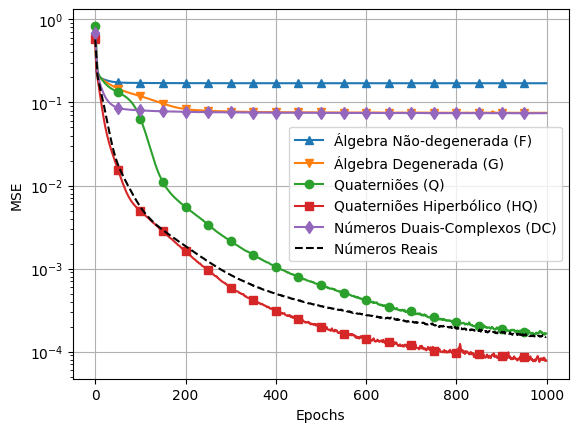

In [ ]:
# plt.figure(figsize=(12,8))

plt.semilogy(h_NonDegenerateV.history['loss'],'-^',label="Álgebra Não-degenerada (F)",markevery=50)
plt.semilogy(h_DegenerateV.history['loss'],'-v',label="Álgebra Degenerada (G)",markevery=50)
plt.semilogy(h_QuatV.history['loss'],'-o',label="Quaterniões (Q)",markevery=50)
plt.semilogy(h_HyperQuatV.history['loss'],'-s',label="Quaterniões Hiperbólico (HQ)",markevery=50)
plt.semilogy(h_DCNV.history['loss'],'-d',label="Números Duais-Complexos (DC)",markevery=50)
plt.semilogy(h_Real.history['loss'],'--k',label="Números Reais")
plt.legend()
plt.grid()

plt.xlabel("Épocas")
plt.ylabel("Erro quadrático médio")

plt.savefig("Figures4D/Experiment_4D_V.pdf")

Text(0, 0.5, 'Maximum Error')

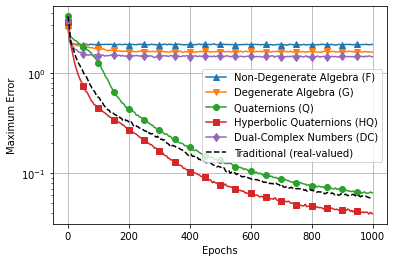

In [ ]:
# plt.figure(figsize=(12,8))

sigma = 2

plt.semilogy(gaussian_filter1d(h_NonDegenerateV.history['MaxAbs'],sigma),'-^',label="Non-Degenerate Algebra (F)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DegenerateV.history['MaxAbs'],sigma),'-v',label="Degenerate Algebra (G)",markevery=50)
plt.semilogy(gaussian_filter1d(h_QuatV.history['MaxAbs'],sigma),'-o',label="Quaternions (Q)",markevery=50)
plt.semilogy(gaussian_filter1d(h_HyperQuatV.history['MaxAbs'],sigma),'-s',label="Hyperbolic Quaternions (HQ)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DCNV.history['MaxAbs'],sigma),'-d',label="Dual-Complex Numbers (DC)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Real.history['MaxAbs'],sigma),'--k',label="Traditional (real-valued)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Épocas")
plt.ylabel("Erro quadrático médio")

# plt.savefig("Figures4D/Experiment_4D_V.pdf")

# Errors produced by the networks with real-valued output weights

In [ ]:
print("MSE (F): %2.2e" % h_NonDegenerateR.history['loss'][-1])
print("MSE (G): %2.2e" % h_DegenerateR.history['loss'][-1])
print("MSE (Q): %2.2e" % h_QuatR.history['loss'][-1])
print("MSE (HQ): %2.2e" % h_HyperQuatR.history['loss'][-1])
print("MSE (DC): %2.2e" % h_DCNR.history['loss'][-1])
print("MSE (R): %2.2e" % h_Real.history['loss'][-1])

MSE (F): 4.86e-04
MSE (G): 6.19e-02
MSE (Q): 2.03e-04
MSE (HQ): 2.10e-04
MSE (DC): 7.66e-02
MSE (R): 1.50e-04


# Errors produced by the networks with vector-valued output weights

In [ ]:
print("MSE (F): %2.2e" % h_NonDegenerateV.history['loss'][-1])
print("MSE (G): %2.2e" % h_DegenerateV.history['loss'][-1])
print("MSE (Q): %2.2e" % h_QuatV.history['loss'][-1])
print("MSE (HQ): %2.2e" % h_HyperQuatV.history['loss'][-1])
print("MSE (DC): %2.2e" % h_DCNV.history['loss'][-1])
print("MSE (R): %2.2e" % h_Real.history['loss'][-1])

MSE (F): 1.79e-01
MSE (G): 7.70e-02
MSE (Q): 2.01e-04
MSE (HQ): 9.32e-05
MSE (DC): 7.60e-02
MSE (R): 1.50e-04
